**Objective:**

The objective of this assignment is to implement a recommendation system using cosine similarity on an anime dataset.

**Tasks:**

**Data Preprocessing:**

* Load the dataset into a suitable data structure (e.g., pandas DataFrame).
Handle missing values, if any.
* Explore the dataset to understand its structure and attributes.


In [1]:
import pandas as pd
import numpy as np

In [2]:
anime_data = pd.read_csv('/content/anime.csv')
anime_data

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [3]:
anime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [4]:
# Check for missing data
anime_data.isnull().sum()

,0
anime_id,0
name,0
genre,62
type,25
episodes,0
rating,230
members,0


In [5]:
# Check for missing data in terms of %
print('Missing data in %\n', round(((anime_data.isna().sum()/len(anime_data))*100), 4))

Missing data in %
 anime_id    0.0000
name        0.0000
genre       0.5043
type        0.2034
episodes    0.0000
rating      1.8708
members     0.0000
dtype: float64


In [6]:
# Check for duplicates
anime_data[anime_data.duplicated()]

,anime_id,name,genre,type,episodes,rating,members


In [7]:
import matplotlib.pyplot as plt
import seaborn as sea

Mean: 6.473901690981432
Median: 6.57


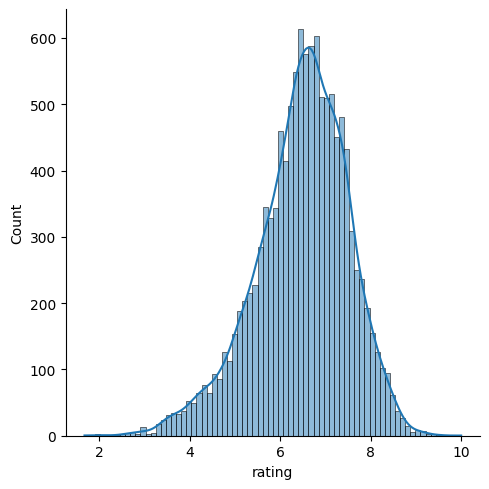

In [8]:
# Check the data distribution to decide which values to be imputed
sea.displot(anime_data['rating'], kde=True)
print('Mean:', anime_data['rating'].mean())
print('Median:', anime_data['rating'].median())

Imputing missing data in 'rating' by median values because the distribution of the data is slightly right skewed and the mean is close to median.

In [9]:
anime_data['rating'].fillna(anime_data['rating'].median(), inplace = True)
anime_data.isnull().sum()

/tmp/ipython-input-2156216489.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  anime_data['rating'].fillna(anime_data['rating'].median(), inplace = True)


,0
anime_id,0
name,0
genre,62
type,25
episodes,0
rating,0
members,0


In [10]:
#print(anime_data[anime_data.isnull().any(axis=1)])

In [11]:
# Imputing data to columns 'genre' and 'type'
for i in range(len(anime_data)):
  if pd.isnull(anime_data.loc[i, 'genre']):
    anime_data.loc[i, 'genre'] = 'Unknown'
  if pd.isnull(anime_data.loc[i, 'type']):
    anime_data.loc[i, 'type'] = 'Unknown'
anime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12294 non-null  object 
 3   type      12294 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12294 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [12]:
# Verification of number of data points imputed by considering the count of null/na to the number of 'Unknown'
count = 0
for i in range(len(anime_data)):
  if anime_data.loc[i, 'type'] == 'Unknown':
    count += 1
print(count)

25


**Feature Extraction:**

* Decide on the features that will be used for computing similarity (e.g., genres, user ratings).
* Convert categorical features into numerical representations if necessary.
Normalize numerical features if required.

In [13]:
non_numeric = anime_data['episodes'].str.isnumeric()
print(non_numeric.value_counts())

episodes
True     11954
False      340
Name: count, dtype: int64


In [14]:
anime_data['episodes_numeric'] = pd.to_numeric(anime_data['episodes'], errors = 'coerce').fillna(-1)
anime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   anime_id          12294 non-null  int64  
 1   name              12294 non-null  object 
 2   genre             12294 non-null  object 
 3   type              12294 non-null  object 
 4   episodes          12294 non-null  object 
 5   rating            12294 non-null  float64
 6   members           12294 non-null  int64  
 7   episodes_numeric  12294 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 768.5+ KB


In [15]:
anime_data.drop('episodes', axis = 1, inplace = True)
anime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   anime_id          12294 non-null  int64  
 1   name              12294 non-null  object 
 2   genre             12294 non-null  object 
 3   type              12294 non-null  object 
 4   rating            12294 non-null  float64
 5   members           12294 non-null  int64  
 6   episodes_numeric  12294 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 672.5+ KB


In [16]:
anime_data['rating'].value_counts()

,count
rating,
6.57,283
6.00,141
7.00,99
6.50,90
6.25,84
...,...
2.98,1
3.44,1
1.92,1


In [17]:
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer

In [18]:
mlb = MultiLabelBinarizer()
genre_features = mlb.fit_transform(anime_data['genre'].str.split(','))
print(genre_features)
genre_df = pd.DataFrame(genre_features, columns = mlb.classes_)
genre_df

[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,...,Shounen,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,Yaoi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12289,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12290,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12291,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12292,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
anime_data = pd.get_dummies(anime_data, columns = ['type'], drop_first = True)
anime_data

,anime_id,name,genre,rating,members,episodes_numeric,type_Music,type_ONA,type_OVA,type_Special,type_TV,type_Unknown
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",9.37,200630,1.0,False,False,False,False,False,False
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",9.26,793665,64.0,False,False,False,False,True,False
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",9.25,114262,51.0,False,False,False,False,True,False
3,9253,Steins;Gate,"Sci-Fi, Thriller",9.17,673572,24.0,False,False,False,False,True,False
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",9.16,151266,51.0,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,4.15,211,1.0,False,False,True,False,False,False
12290,5543,Under World,Hentai,4.28,183,1.0,False,False,True,False,False,False
12291,5621,Violence Gekiga David no Hoshi,Hentai,4.88,219,4.0,False,False,True,False,False,False
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,4.98,175,1.0,False,False,True,False,False,False


In [20]:
anime_data['type_Music'] = anime_data['type_Music'].astype(int)
anime_data['type_ONA'] = anime_data['type_ONA'].astype(int)
anime_data['type_TV'] = anime_data['type_TV'].astype(int)
anime_data['type_OVA'] = anime_data['type_OVA'].astype(int)
anime_data['type_Special'] = anime_data['type_Special'].astype(int)
anime_data['type_Unknown'] = anime_data['type_Unknown'].astype(int)
anime_data

,anime_id,name,genre,rating,members,episodes_numeric,type_Music,type_ONA,type_OVA,type_Special,type_TV,type_Unknown
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",9.37,200630,1.0,0,0,0,0,0,0
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",9.26,793665,64.0,0,0,0,0,1,0
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",9.25,114262,51.0,0,0,0,0,1,0
3,9253,Steins;Gate,"Sci-Fi, Thriller",9.17,673572,24.0,0,0,0,0,1,0
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",9.16,151266,51.0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,4.15,211,1.0,0,0,1,0,0,0
12290,5543,Under World,Hentai,4.28,183,1.0,0,0,1,0,0,0
12291,5621,Violence Gekiga David no Hoshi,Hentai,4.88,219,4.0,0,0,1,0,0,0
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,4.98,175,1.0,0,0,1,0,0,0


In [21]:
numeric_data = anime_data[['rating', 'members', 'episodes_numeric']].copy()
numeric_data

,rating,members,episodes_numeric
0,9.37,200630,1.0
1,9.26,793665,64.0
2,9.25,114262,51.0
3,9.17,673572,24.0
4,9.16,151266,51.0
...,...,...,...
12289,4.15,211,1.0
12290,4.28,183,1.0
12291,4.88,219,4.0
12292,4.98,175,1.0


<Axes: xlabel='rating', ylabel='Count'>

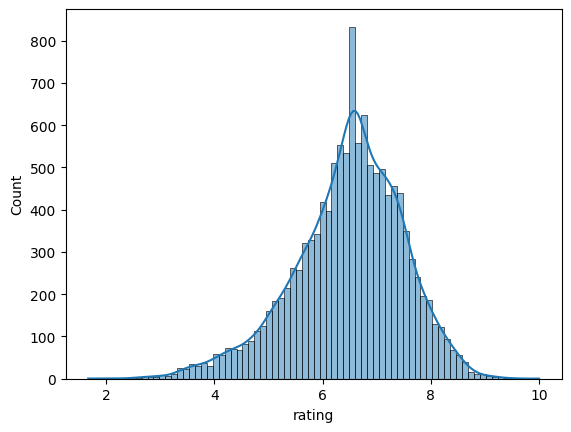

In [22]:
sea.histplot(numeric_data['rating'], kde=True)

In [23]:
numeric_data.columns

Index(['rating', 'members', 'episodes_numeric'], dtype='object')

In [24]:
anime_id_data = anime_data[['anime_id', 'name']]
anime_id_data

,anime_id,name
0,32281,Kimi no Na wa.
1,5114,Fullmetal Alchemist: Brotherhood
2,28977,Gintama°
3,9253,Steins;Gate
4,9969,Gintama&#039;
...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami
12290,5543,Under World
12291,5621,Violence Gekiga David no Hoshi
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...


In [25]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(numeric_data)
numeric_data = pd.DataFrame(scaled_data, columns = numeric_data.columns)
numeric_data

,rating,members,episodes_numeric
0,0.924370,0.197872,0.001100
1,0.911164,0.782770,0.035734
2,0.909964,0.112689,0.028587
3,0.900360,0.664325,0.013744
4,0.899160,0.149186,0.028587
...,...,...,...
12289,0.297719,0.000203,0.001100
12290,0.313325,0.000176,0.001100
12291,0.385354,0.000211,0.002749
12292,0.397359,0.000168,0.001100


In [26]:
type_data = anime_data[['type_Music', 'type_ONA', 'type_TV', 'type_OVA', 'type_Special', 'type_Unknown']]
type_data

,type_Music,type_ONA,type_TV,type_OVA,type_Special,type_Unknown
0,0,0,0,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0
...,...,...,...,...,...,...
12289,0,0,0,1,0,0
12290,0,0,0,1,0,0
12291,0,0,0,1,0,0
12292,0,0,0,1,0,0


In [27]:
final_data = pd.concat([genre_df, numeric_data, type_data], axis = 1)
final_data

,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,...,Yaoi,rating,members,episodes_numeric,type_Music,type_ONA,type_TV,type_OVA,type_Special,type_Unknown
0,0,0,0,0,0,0,0,0,0,0,...,0,0.924370,0.197872,0.001100,0,0,0,0,0,0
1,1,0,0,0,0,1,0,1,0,0,...,0,0.911164,0.782770,0.035734,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0.909964,0.112689,0.028587,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0.900360,0.664325,0.013744,0,0,1,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0.899160,0.149186,0.028587,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12289,0,0,0,0,0,0,0,0,0,0,...,0,0.297719,0.000203,0.001100,0,0,0,1,0,0
12290,0,0,0,0,0,0,0,0,0,0,...,0,0.313325,0.000176,0.001100,0,0,0,1,0,0
12291,0,0,0,0,0,0,0,0,0,0,...,0,0.385354,0.000211,0.002749,0,0,0,1,0,0
12292,0,0,0,0,0,0,0,0,0,0,...,0,0.397359,0.000168,0.001100,0,0,0,1,0,0


**Recommendation System:**

* Design a function to recommend anime based on cosine similarity.
* Given a target anime, recommend a list of similar anime based on cosine similarity scores.
* Experiment with different threshold values for similarity scores to adjust the recommendation list size.

In [28]:
# Calculate cosine similarities between variables
from sklearn.metrics.pairwise import cosine_similarity

In [29]:
# Apply cosine similarity function from the package sklearn and module pairwise
similarity_matrix = cosine_similarity(final_data)
similarity_matrix_df = pd.DataFrame(similarity_matrix, index = anime_data['name'], columns = anime_data['name'])
similarity_matrix_df

name,Kimi no Na wa.,Fullmetal Alchemist: Brotherhood,Gintama°,Steins;Gate,Gintama&#039;,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou,Hunter x Hunter (2011),Ginga Eiyuu Densetsu,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare,Gintama&#039;: Enchousen,...,Super Erotic Anime,Taimanin Asagi 3,Teleclub no Himitsu,Tenshi no Habataki Jun,The Satisfaction,Toushindai My Lover: Minami tai Mecha-Minami,Under World,Violence Gekiga David no Hoshi,Violence Gekiga Shin David no Hoshi: Inma Densetsu,Yasuji no Pornorama: Yacchimae!!
name,,,,,,,,,,,,,,,,,,,,,
Kimi no Na wa.,1.000000,0.146682,0.131271,0.211269,0.130925,0.320054,0.168336,0.345408,0.135738,0.128193,...,0.095980,0.334766,0.103130,0.092048,0.093361,0.086094,0.090398,0.109870,0.113042,0.173061
Fullmetal Alchemist: Brotherhood,0.146682,1.000000,0.428802,0.369395,0.431095,0.484943,0.684688,0.253613,0.334228,0.425143,...,0.068130,0.083718,0.073207,0.065346,0.066274,0.061123,0.064174,0.078007,0.080239,0.122830
Gintama°,0.131271,0.428802,1.000000,0.308985,0.999918,0.364280,0.531255,0.254463,0.941589,0.999901,...,0.070301,0.086359,0.075537,0.067416,0.068378,0.063055,0.066208,0.080478,0.082792,0.126750
Steins;Gate,0.211269,0.369395,0.308985,1.000000,0.311528,0.347333,0.413590,0.172626,0.147694,0.303569,...,0.100315,0.123275,0.107791,0.096217,0.097584,0.089997,0.094491,0.114849,0.118150,0.180868
Gintama&#039;,0.130925,0.431095,0.999918,0.311528,1.000000,0.363668,0.532333,0.253665,0.941274,0.999703,...,0.069507,0.085385,0.074684,0.066655,0.067606,0.062344,0.065461,0.079570,0.081857,0.125317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Toushindai My Lover: Minami tai Mecha-Minami,0.086094,0.061123,0.063055,0.089997,0.062344,0.070867,0.075460,0.363492,0.065793,0.062015,...,0.999706,0.390039,0.999123,0.999894,0.999841,1.000000,0.999944,0.998286,0.997795,0.715129
Under World,0.090398,0.064174,0.066208,0.094491,0.065461,0.074411,0.079229,0.366657,0.069083,0.065117,...,0.999906,0.392192,0.999509,0.999992,0.999974,0.999944,1.000000,0.998848,0.998439,0.717963
Violence Gekiga David no Hoshi,0.109870,0.078007,0.080478,0.114849,0.079570,0.090441,0.096326,0.380578,0.083964,0.079145,...,0.999412,0.401436,0.999861,0.999034,0.999170,0.998286,0.998848,1.000000,0.999968,0.729856


In [30]:
# Defining a function to provide recommendations of similar anime shows
def recommend_function(anime_name, anime_data, similarity_matrix, num_recommendations, threshold, objective):
  # This is a function to list anime shows that are similar or dissimilar
  # In the objective part use 'similar' or 'dissimilar'
  target_id = anime_data[anime_data['name'] == anime_name].index[0]
  #print(target_id)
  similarity_scores = similarity_matrix.iloc[target_id]
  #print(similarity_scores)

  if objective == 'similar':
    similar_anime = similarity_scores[similarity_scores > threshold]
    similar_anime = similar_anime.sort_values(ascending = False)
  elif objective == 'dissimilar':
    similar_anime = similarity_scores[similarity_scores < threshold]
    similar_anime = similar_anime.sort_values(ascending = True)
  else:
    print("Please use 'similar' or 'dissimilar' for objective selection.")

  count = 0
  output_list = []
  for name, score in similar_anime.items():
    recommended_info = anime_data[anime_data['name'] == name].iloc[0]
    output_list.append('Name: {}, Score: {:.6f}, Genre: {}, Rating: {:.2f}'.format(name, score, recommended_info['genre'], recommended_info['rating']))
    count += 1
    if count == num_recommendations:
      break

  return output_list

In [31]:
# Case 1: List of 10 very similar shows to Manga
recommend_function('Manga', anime_data, similarity_matrix_df, 10, 0.9, 'similar')

['Name: Manga, Score: 1.000000, Genre: Comedy, Rating: 4.52',
 'Name: Doubutsu Olympic Taikai, Score: 0.999999, Genre: Comedy, Rating: 4.51',
 'Name: Akagaki Genzou: Tokuri no Wakare, Score: 0.999998, Genre: Comedy, Rating: 4.50',
 'Name: Kemeko no Love, Score: 0.999991, Genre: Comedy, Rating: 4.48',
 'Name: Made in Japan, Score: 0.999953, Genre: Comedy, Rating: 4.43',
 'Name: Ojiichan ga Kaizoku Datta Koro, Score: 0.999930, Genre: Comedy, Rating: 4.41',
 'Name: Tonari no Yarou, Score: 0.999903, Genre: Comedy, Rating: 4.65',
 'Name: Mado, Score: 0.999749, Genre: Comedy, Rating: 4.73',
 'Name: Cofun Gal no Coffy: Juuninin to Ikareru Kofun-tachi, Score: 0.999689, Genre: Comedy, Rating: 4.29',
 'Name: Ohi-sama to Kaeru, Score: 0.999633, Genre: Comedy, Rating: 4.27']

In [32]:
# Case 2: List of top 10 somewhat similar shows to Naruto
recommend_function('Naruto', anime_data, similarity_matrix_df, 10, 0.8, 'similar')

['Name: Naruto, Score: 1.000000, Genre: Action, Comedy, Martial Arts, Shounen, Super Power, Rating: 7.81',
 'Name: Naruto: Shippuuden, Score: 0.997417, Genre: Action, Comedy, Martial Arts, Shounen, Super Power, Rating: 7.94',
 'Name: Katekyo Hitman Reborn!, Score: 0.911991, Genre: Action, Comedy, Shounen, Super Power, Rating: 8.37',
 'Name: Naruto: Shippuuden Movie 4 - The Lost Tower, Score: 0.897534, Genre: Action, Comedy, Martial Arts, Shounen, Super Power, Rating: 7.53',
 'Name: Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsugu Mono, Score: 0.897424, Genre: Action, Comedy, Martial Arts, Shounen, Super Power, Rating: 7.50',
 'Name: Boruto: Naruto the Movie, Score: 0.896581, Genre: Action, Comedy, Martial Arts, Shounen, Super Power, Rating: 8.03',
 'Name: Naruto Soyokazeden Movie: Naruto to Mashin to Mitsu no Onegai Dattebayo!!, Score: 0.891273, Genre: Action, Comedy, Martial Arts, Shounen, Super Power, Rating: 7.11',
 'Name: Dragon Ball Z, Score: 0.872963, Genre: Action, Adventure, Co

In [33]:
# Case 3: List of top 5 dissimilar shows to One Piece
recommend_function('One Piece', anime_data, similarity_matrix_df, 5, 0.02, 'dissimilar')

['Name: Platonic Chain: Ansatsu Jikkouchuu, Score: 0.000004, Genre: Sci-Fi, Slice of Life, Rating: 1.67',
 'Name: Tenkuu Danzai Skelter+Heaven, Score: 0.007073, Genre: Mecha, Sci-Fi, Rating: 2.00',
 'Name: Utsu Musume Sayuri, Score: 0.009418, Genre: Comedy, Dementia, Rating: 2.14',
 'Name: Hametsu no Mars, Score: 0.016056, Genre: Horror, Sci-Fi, Rating: 2.37',
 'Name: Manga Edo Erobanashi, Score: 0.019780, Genre: Comedy, Hentai, Historical, Rating: 2.86']

**Evaluation:**

* Split the dataset into training and testing sets.
* Evaluate the recommendation system using appropriate metrics such as precision, recall, and F1-score.
* Analyze the performance of the recommendation system and identify areas of improvement.

In [34]:
from sklearn.model_selection import train_test_split as tts

In [35]:
# Content-Based Filtering
train_data, test_data = tts(final_data, test_size = 0.2, random_state = 42)
print(train_data.shape)
print(test_data.shape)

(9835, 92)
(2459, 92)


In [36]:
train_similarity_matrix = cosine_similarity(train_data)
print(train_similarity_matrix.shape)

test_similarity_matrix = cosine_similarity(test_data)
print(test_similarity_matrix.shape)

(9835, 9835)
(2459, 2459)


In [37]:
# Check if similar anime in test set share genres
print(test_data.iloc[0][0])
#print(test_data
test_sample = test_data.sample(1)
print(test_sample)
#test_genres = set(test_sample['genre'].iloc[0])

#recommendations = recommend_function(test_sample['name'].iloc[0], test_data, test_similarity_matrix)
#shared_genres = [len(test_genres.intersection(set(g))) for g in recommendations['genre']]

#print(f"Average shared genres: {np.mean(shared_genres):.1f}/total")

0.0
       Adventure   Cars   Comedy   Dementia   Demons   Drama   Ecchi  \
9073           0      0        0          0        1       1       0   

       Fantasy   Game   Harem  ...  Yaoi    rating   members  \
9073         1      0       0  ...     0  0.512605  0.000122   

      episodes_numeric  type_Music  type_ONA  type_TV  type_OVA  type_Special  \
9073          0.029137           0         0        1         0             0   

      type_Unknown  
9073             0  

[1 rows x 92 columns]


/tmp/ipython-input-3268742789.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(test_data.iloc[0][0])
